Why do people build committee make important decisions? Why do multiple medical doctors decide the necessity of a heart surgery? Why are there multiple judges in a court? Why do citizens choose their rulers by voting? All stem from the belief that **aggregating the opinions of multiple experts leads to better decisions**. 
Some decisions are too complex to be made by single expert because it requires expertise in multiple fields. In those cases, people establish panels of members coming from diverse backgrounds. Some other decisions are not that complex but too risky. In those cases people establish panels of members coming from the same background to increase the robustness of the outcomes.

For similar reasons, we build **ensembles** of machine learning models. Each model captures a local world view based on its individual set of observations. Aggregating the predictions of a group of models can lead to either more robust or more accurate predictions. Training the models in the ensemble:
  - **in parallel** improves the robustness of the predictions, addressed by **bagging methods**,
  - **in sequence** improves the accuracy of the predictions, addressed by **boosting methods**.

# Bootstrap Aggregation (Bagging)

Denote $f_S(x)$ as a predictor learned on a data set $S$. If we collect a new data set $S'$ from the same data generating process and train the same model on it, leading to a predictor $f_S'(x)$, and treat the mean of the two models as a new model, we get:

\begin{align*}
f_{S, S'}(x) = \frac{1}{2} f_S(x) + \frac{1}{2} f_{S'}(x)
\end{align*}

The bias of this model will be the same as the bias of the original model:

\begin{align*}
\mathbb{E}[f_{S, S'}(x)] &= \mathbb{E}\left [ \frac{1}{2} f_S(x) + \frac{1}{2} f_{S'}(x) \right ] \\
  &= \frac{1}{2} \mathbb{E}[f_S(x)] + \frac{1}{2} \mathbb{E}[f_{S'}(x)] \\
  &= \mathbb{E}[f_S(x)]
\end{align*}

However, the variance of the new model will be lower than the variance of the original model:

\begin{align*}
Var[f_{S, S'}(x)] &= Var \left [ \frac{1}{2} f_S(x) + \frac{1}{2} f_{S'}(x) \right ] \\
  & = \frac{1}{4} Var[f_S(x)] + \frac{1}{4} Var[f_{S'}(x)] \\
  &= \frac{1}{2} Var[f_S(x)].
\end{align*}

Thus far the result appears to only reiterate the trivial fact that collecting more data is beneficial. However, another implication of this result is that we can reduce the variance of our model if we can **simulate** or **approximate** the process of collecting more data. We can for instance generate new data sets by choosing data points from the original data set uniformly at random with replacement:

\begin{align*}
  S' = \{ x_{j_k} : j_k \sim \mathcal{U}(\{1, \dots, m\}), k= 1, \dots, m' \}
\end{align*}

where $\mathcal{U}$ chooses an index from the set $\{1, \dots, m\}$ with equal probability. The chosen element is not removed from $S$, hence it is possible that the same element is chosen multiple times. This process is called **bootstrapping**.

Let $S_1, \dots, S_K$ be $K$ data sets bootstrapped from $S$. Let us then train $K$ models $f_{S_1}, \dots, f_{S_K}$ on each of the data sets and aggregate their predictions:

\begin{align*}
  f_{S_1, \dots, S_K}(x) = \frac{1}{K} \sum_{k=1}^K f_{S_k}(x).
\end{align*}

This is called **bootstrap aggregation** or **bagging**. Note that the ensemble is built by training the models in parallel, i.e. a model $f_{S_k}(x)$ is trained independently from other models.

As you might remember from the previous chapter, choosing $\sigma^2$ too small causes kernel regression to overfit. The example implementation below illustrates how bagging can be used to reduce the variance of the model and thus reduce overfitting. This way, bagging can be used to improve the **robustness** of the model. It does not increase model capacity, i.e. it does not improve the expected accuracy of the model.

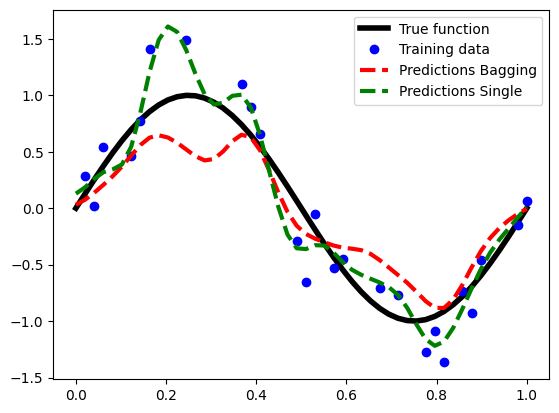

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
from scipy.spatial.distance import cdist

# Generate the data
inputs = np.linspace(0, 1, 50)
outputs = np.sin(2*np.pi*inputs)                  
labels = outputs + np.random.randn(inputs.shape[0])*0.25

num_samples = inputs.shape[0]
num_train_samples = num_samples//2

inputs = np.expand_dims(inputs, axis=1)
idx = np.random.permutation(num_samples) 
inputs_train = inputs[idx[:num_train_samples]]
labels_train = labels[idx[:num_train_samples]]

class KernelLinearRegression:
    def __init__(self, lambda_reg=0, length_scale=0.1):
        self.lambda_reg = 0.1
        self.sigma = length_scale
      
    def compute_rbf_kernel(self, X, Xp):
        dist = cdist(X, Xp, 'euclidean') 
        return np.exp(-dist**2/(2*self.sigma**2))

    def precompute_a(self, inputs_train, labels_train):
        K = self.compute_rbf_kernel(inputs_train, inputs_train)
        self.a = np.linalg.inv(K + \
            self.lambda_reg * np.eye(inputs_train.shape[0])) @ labels_train

    def predict(self, inputs_train, inputs):
        Kp = self.compute_rbf_kernel(inputs_train, inputs)
        predictions = Kp.T @ self.a
        return predictions

models = []
inputs_bootstrap = []
labels_bootstrap = []

num_ensembles = 20
sigma2 = 0.05

# Size of the boostrapped datasets
num_bootstrap_samples = 10 

for ii in range(num_ensembles):

    # bootstrap
    idx = np.random.randint(0, num_train_samples, num_bootstrap_samples)
    inputs_bootstrap.append(inputs_train[idx])
    labels_bootstrap.append(labels_train[idx])

    # train predictor ii
    model_ii = KernelLinearRegression(length_scale=sigma2) 
    model_ii.precompute_a(inputs_bootstrap[ii], labels_bootstrap[ii])
    models.append(model_ii)

# Predict by aggregating the predictions of the models
for ii in range(num_ensembles):
    predictions = models[ii].predict(inputs_bootstrap[ii], inputs)/num_ensembles
    if ii == 0:
        predictions_agg = predictions
    else:
        predictions_agg += predictions

# single model
model_single = KernelLinearRegression(length_scale=sigma2)
model_single.precompute_a(inputs_train, labels_train)
predictions_single = model_single.predict(inputs_train, inputs)

plt.plot(inputs,outputs,'k-', label="True function", linewidth=4)
plt.plot(inputs_train,labels_train,'bo', label="Training data")
plt.plot(inputs,predictions_agg,'r--', 
         label="Predictions Bagging", linewidth=3)
plt.plot(inputs,predictions_single,'g--', 
         label="Predictions Single", linewidth=3)
plt.legend(loc="upper right")
plt.show()

# Boosting

It is also possible to build ensembles to increase the capacities of predictors. Given a data set a data set $S = \{(x_i, y_i) : i = 1, \dots, m\}$ and the task of finding a predictor $f(x)$ that minimizes the loss function $L(f(x), y)$ on,
boosting methods follow the recipe below for building such ensembles:

   - Choose a **weak learner** $f_k(x)$, i.e. a predictor that performs only marginally better than random guess.
   - Train many copies of this weak learner in sequence, i.e. each predictor is trained using the predictions of the previous predictor.
   - Give weights $w_i$ to training data points proportional to the error of the previous predictors on them.
   - Give weights $\alpha_k$ to the predictors proportional to their performance on the training data.

We present below the two most popular boosting approaches below: Adaptive Boosting (AdaBoost) and Gradient Boosting.

**Adaptive Boosting (AdaBoost):**

1. Initialize the weights of the data points $w_i = \frac{1}{m}$, $i = 1, \dots, m$.
2. For $k = 1, \dots, K$ do:
   1. Train a weak learner $f_k(x)$ on the data set $S$ with weights $w_1, \dots, w_m$.
   2. Compute the weighted loss of the model:
      \begin{align*}
        \epsilon_k = \sum_{i=1}^m w_i L(f_k(x_i), y_i)
      \end{align*}
   3. Compute the weight of the model:
      \begin{align*}
        \alpha_k = \frac{1}{2} \log \left( \frac{1 - \epsilon_k}{\epsilon_k} \right)
      \end{align*}
   4. Update the weights of the data points:
      \begin{align*}
        w_i := w_i \exp \left( \alpha_k L(f_k(x_i), y_i) \right)
      \end{align*}
   5. Normalize the weights:
      \begin{align*}
        w_i := \frac{w_i}{\sum_{j=1}^m w_j}
      \end{align*}
  3. Output the model:

      \begin{align*}
        f(x) = \sum_{k=1}^K \alpha_k f_k(x)
      \end{align*}

**Gradient Boosting:** 

1. Initialize the model with a constant predictor $f_0(x) = \arg \min_\alpha \sum_{i=1}^m L(\alpha, y_i)$.
2. For $k = 1, \dots, K$ do:
   1. Compute the **pseudo-residuals**:

      \begin{align*}
        r_{i, k} = - \left. \frac{\partial L(f(x_i), y_i)}{\partial f(x_i)} \right |_{f(x) = f_{k-1}(x)}
      \end{align*}

      for $i = 1, \dots, m$.

    2. Train a weak learner $f_k(x)$ on  $S=\{(x_i, r_{i, k}) : i = 1, \dots, m\}$.
    
    3. Compute the weight of the model:
    
      \begin{align*}
        \alpha_k = \arg \min_{\alpha'} \sum_{i=1}^m L(f_{k-1}(x_i) + \alpha' f_k(x_i), y_i)
      \end{align*}
    4. Update the model:

      \begin{align*}
        f_k(x) := f_{k-1}(x) + \alpha_k f_k(x)
      \end{align*}
      
  3. Output the model:

      \begin{align*}
        f(x) = f_K(x)
      \end{align*}

The two algorithms share the same recipe described at the beginning of the section. Their major differences are as follows:

   - AdaBoost uses the previously trained model to reweight the data points, while Gradient Boosting uses the previously trained models to compute the pseudo-residuals.
   - AdaBoost trains the models on the original data where data points are weighted by importance, while Gradient Boosting trains the models on the pseudo-residuals, i.e. the direction of the error of the previous model.
   
# Federated Learning

The explosion in the scale of data has led to the emergence of two problems:
- Data is too big to train a machine learning model on a single machine, hence the computation needs to be distributed.
- Data is curated by multiple parties (e.g. hospitals) and cannot be aggregated due to privacy concerns

Application of ensemble learning to distributed computing, called **Federated Learning**, offers a solution to both of these problems. The idea is to train a model on a distributed data set without aggregating the data. A basic federated learning setup is as follows:

 - Data sets $S_1, \dots, S_K$ are hosted at $K$ parties, called **clients**.
 - The goal is to fit a single model $f_\theta(x)$ with free parameters $\theta$ to all of the data sets. The key assumption is that the data sets are sampled from the same distribution, i.e. data points represent patients of the same disease who are treated at different hospitals.
 - A central **server** coordinates the training process.
 - Clients do not share their data with the other clients or the server.

Federated learning is a young and vibrant research field with only few established algorithms. A popular approach, called **Federated Averaging (FedAvg)**, applies the idea of stochastic gradient descent to federated learning. The pseudocode of the algorithm is as follows:

- Initialize the global parameters $\theta_g$ and regularization constant $\lambda > 0$
- Repeat until communicated budget exhausted:
  - Sample a subset of clients $S_1, \dots, S_K$ from the client pool
  - For each client $k = 1, \dots, K$:
    - Initialize the local parameters to global $\theta_k := \theta_g$
    - Do gradient descent updates on the local data set $S_k$
    - Send the local parameters $\theta_k$ and data set size $m_k := |S_k|$ to server
  - The server updates the global parameters weighted by the data set sizes: $\theta_g :=  \sum_{k=1}^K \frac{m_k}{m} \theta_k$,
  where $m = \sum_{k=1}^K m_k$.
  - The server distributes the updated global parameters to the clients.

More details can be found at the original source:

[McMahan, H.B. et al., (2017) Communication-Efficient Learning of Deep Networks from Decentralized Data, AISTATS, 2017](https://arxiv.org/abs/1602.05629)

There exist many other variants of federated learning that address different problems. For instance, **personalized** federated learning approaches assume that the clients have different data distributions and the goal of their communication is to transfer common knowledge between each other.